In [41]:
# Import libraries
import psutil
import pandas as pd
import numpy as np
from fuzzywuzzy import process, fuzz
import glob
import time
import boto3
import os
from datetime import date

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=False)
import seaborn as sns
import matplotlib.pyplot as plt

import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# import statistics
# from nltk.tokenize import sent_tokenize, word_tokenize

import warnings
warnings.filterwarnings('ignore')

### Load cleaned data

In [2]:
psutil.virtual_memory()

svmem(total=8461193216, available=2845192192, percent=66.4, used=5616001024, free=2845192192)

In [ ]:
# Read in commentors
commentors = pd.read_csv('data/cleaned/comments.csv', usecols=['commentor'])

### Resolve commentors suspected to be the same individual

In [ ]:
# number of unique commentors
commentors.commentor.nunique()

In [ ]:
# get an example of a potential single commentor under two different usernames
commentors[commentors.commentor.str.contains("All Eyez On Me")]['commentor'].unique()

In [ ]:
# get another example
commentors[commentors.commentor.str.contains("Native Americans")]['commentor'].unique()

In [ ]:
fuzz.partial_ratio('"All Eyez On Me" in theaters NOW!!!','"All Eyez On Me" in theaters june 16 2017')

In [ ]:
unique_commentors = pd.DataFrame(commentors.commentor.unique())
unique_commentors.columns = ['commentor']
unique_commentors = unique_commentors.sort_values(by=['commentor']).reset_index(drop=True)
df = unique_commentors[:1000]

In [ ]:
%%time

# Create df of unique commentor's usernames
unique_commentors = pd.DataFrame(commentors.commentor.unique())
unique_commentors.columns = ['commentor']
unique_commentors = unique_commentors.sort_values(by=['commentor']).reset_index(drop=True)

increment = 1000
for i in range(0,round(unique_commentors.shape[0]), increment):
    start_time = time.time()
    print(i)
    df = unique_commentors[i:i+increment]

    # Compare usernames to find potential split entities
    potential_matches = list()
    for name in df.commentor:
        if len(name) < 10:
            continue
        for other_name in df.commentor:
            if name != other_name and len(other_name) > 10:
                score = fuzz.partial_ratio(name, other_name)
                if score >= 83:
                    potential_matches.append([name,other_name,score])

    potential_matches_df = pd.DataFrame(potential_matches, columns=['username1','username2','score'])
    potential_matches_df.to_csv(f'tmp_entity_resolution/{i}.csv', header=False, index=False)
    print(time.time() - start_time)

In [ ]:
# Read in resolved usernames
resolved_usernames_files = glob.glob('tmp_entity_resolution/*.csv')
data = list()

for filename in resolved_usernames_files:
    df = pd.read_csv(filename, names=['commentor1','commentor2','score'])
    data.append(df)

resolved_usernames = pd.concat(data, axis=0, ignore_index=True)
resolved_usernames.shape

In [ ]:
# Calculate various ratios
resolved_usernames['ratio'] = resolved_usernames.apply(lambda x: fuzz.ratio(x.commentor1, x.commentor2), axis=1)
resolved_usernames['partial_token_set_ratio'] = resolved_usernames.apply(lambda x: fuzz.partial_token_set_ratio(x.commentor1, x.commentor2), axis=1)
resolved_usernames['token_sort_ratio'] = resolved_usernames.apply(lambda x: fuzz.token_sort_ratio(x.commentor1, x.commentor2), axis=1)
resolved_usernames['WRatio'] = resolved_usernames.apply(lambda x: fuzz.WRatio(x.commentor1, x.commentor2), axis=1)
resolved_usernames['avg_score'] = resolved_usernames[['score', 'ratio','partial_token_set_ratio','token_sort_ratio']].mean(axis=1)
high_confidence_matches = resolved_usernames[resolved_usernames.WRatio >= 88]
high_confidence_matches.to_csv('tmp_resolved_entities/high_confidence_matches.csv', header=True, index=False)

In [ ]:
# example of a potential single commentor operating under different usernames 
high_confidence_matches[high_confidence_matches.commentor1 == 'joetoronto'].head()

In [ ]:
# Create mapping between duplicate name and resolved name
resolved_commentors = dict()
for i in range(0, len(high_confidence_matches)):
    commentor1 = high_confidence_matches['commentor1'].iloc[i]
    commentor2 = high_confidence_matches['commentor2'].iloc[i]
    if commentor2 not in resolved_commentors.keys():
        if commentor1 not in resolved_commentors.keys():
            resolved_commentors[commentor2] = commentor1

In [ ]:
resolved_commentors

In [ ]:
# Load entire comment dataset
commentors = pd.read_csv('data/cleaned/comments.csv', header=0)
commentors.head()

In [ ]:
# Map resolved usernames
commentors['commentor_resolved'] = commentors['commentor'].map(resolved_commentors)
commentors['commentor_resolved'].fillna(commentors['commentor'], inplace=True)

In [ ]:
# Inspect resolved commentors
# commentors.groupby(['commentor_resolved','commentor']).size().reset_index()
original_num_commentors = commentors['commentor'].nunique()
resolved_num_commentors = commentors['commentor_resolved'].nunique()
print(f'Original # Commentors: {original_num_commentors}')
print(f'Resolved # Commentors: {resolved_num_commentors}')
print(f'Diff: {original_num_commentors - resolved_num_commentors}')

In [ ]:
commentors.to_csv('data/cleaned/comments_w_resolved_commentor.csv', header=True, index=False)

### Upload updated dataset to S3

In [ ]:
s3 = boto3.client('s3')
bucket = 'ml-guild-project-pft-comments'
s3.upload_file('data/cleaned/comments_w_resolved_commentor.csv', bucket, 'data/cleaned/comments_w_resolved_commentor.csv')

### Split comment dataset into years

In [190]:
psutil.virtual_memory()

svmem(total=8461193216, available=1853620224, percent=78.1, used=6607572992, free=1853620224)

In [ ]:
# Break comments dataset into individual years
commentors = pd.read_csv('data/cleaned/comments_w_resolved_commentor.csv', parse_dates=['comment_datetime_clean'])
commentors['cyear'] = commentors.comment_datetime_clean.dt.year
for year in commentors.cyear.unique():
    df = commentors[commentors.comment_datetime_clean.dt.year == year]
    df.to_csv(f'tmp_comments_by_year/comments_w_resolved_commentor_{year}.csv',header=True, index=False)

### Generate behavior features for a single year

In [189]:
df = pd.read_csv('tmp_comments_by_year/comments_w_resolved_commentor_2020.csv', parse_dates=['comment_datetime_clean'])
df.shape

(195692, 7)

In [5]:
year = 2020
[os.remove(f'tmp_features_by_year/{f}') for f in os.listdir('tmp_features_by_year/') if '.ipynb' not in f]

[None, None, None, None, None, None, None, None, None, None, None]

In [6]:
# Calculate total # comments
num_comments = pd.DataFrame(df.groupby('commentor_resolved').size())
num_comments.columns = ['num_comments']
num_comments['num_comments_zscore'] = (num_comments['num_comments'] - num_comments['num_comments'].mean())/num_comments['num_comments'].std(ddof=0)
num_comments.to_csv(f'tmp_features_by_year/num_comments_{year}.csv', header=True, index=True)
num_comments.head()

num_comments  num_comments_zscore
commentor_resolved                                          
#The-Best-Fans-in-the-NFL           234             3.683055
( . Y . )                            39             0.360878
*Legion*                              1            -0.286520
-                                    14            -0.065042
.                                     5            -0.218373

In [ ]:
fig = go.Figure(data=go.Scatter(x=num_comments['num_comments'], y=num_comments['num_comments_zscore'], mode='markers', marker=dict(size=5)))
fig.update_layout(height=600, width=600)
fig.show()

In [ ]:
fig = go.Figure(data=[go.Histogram(x=num_comments.num_comments.values, histfunc='sum', histnorm='', cumulative_enabled=False)])
fig.show()

In [7]:
# calculate total number of articles posted in 2020
# articles_post_date = pd.read_csv('data/cleaned/articles.csv', header=0, usecols=['post_datetime'], parse_dates=['post_datetime'])
# articles_post_date['year'] = articles_post_date['post_datetime'].dt.year
# articles_post_date_2020 = articles_post_date[articles_post_date['year'] == year]
# num_articles = articles_post_date_2020.shape[0]

#2 Calculate the total number of unique articles commented on by each commenter
comments_by_articles = pd.DataFrame(df.groupby('commentor_resolved')['article_url'].nunique())
comments_by_articles.columns = ['unique_articles_commented_on']
# comments_by_articles['total_articles_published_in_year'] = num_articles
comments_by_articles['articles_commented_on_times_above_mean'] = comments_by_articles['unique_articles_commented_on'] / comments_by_articles['unique_articles_commented_on'].mean()
comments_by_articles.to_csv(f'tmp_features_by_year/comments_by_articles_{year}.csv', header=True, index=True)
comments_by_articles.head()

unique_articles_commented_on  \
commentor_resolved                                        
#The-Best-Fans-in-the-NFL                           205   
( . Y . )                                            35   
*Legion*                                              1   
-                                                    14   
.                                                     5   

                           articles_commented_on_times_above_mean  
commentor_resolved                                                 
#The-Best-Fans-in-the-NFL                               12.509807  
( . Y . )                                                2.135821  
*Legion*                                                 0.061023  
-                                                        0.854328  
.                                                        0.305117

In [ ]:
fig = go.Figure(data=go.Scatter(x=comments_by_articles['unique_articles_commented_on'], y=comments_by_articles['articles_commented_on_times_above_mean'], mode='markers', marker=dict(size=5)))
fig.update_layout(height=600, width=600)
fig.show()

In [8]:
#3 Calculate the time of day commenters posted
def times_of_date_by_hour(hour):
    if hour >= 5 and hour < 12:
        return 'morning'
    if hour >= 12 and hour < 17:
        return 'afternoon'
    if hour >= 17 and hour < 21:
        return 'evening'
    if hour >= 21 or hour < 5:
            return 'night'
    
df['comment_time_of_day'] = df.comment_datetime_clean.dt.hour.apply(times_of_date_by_hour)
comments_by_time_of_day = pd.pivot_table(df[['article_url','comment_time_of_day','commentor_resolved']],
                                         index=['commentor_resolved'],
                                         columns=['comment_time_of_day'],
                                         aggfunc='count',
                                         fill_value=0
                                        )
comments_by_time_of_day.columns = comments_by_time_of_day.columns.droplevel()
comments_by_time_of_day.columns = [f'comments_made_during_{c}' for c in comments_by_time_of_day.columns]
comments_by_time_of_day['total_comments'] = comments_by_time_of_day.sum(axis=1)

comments_by_time_of_day['percent_comments_made_during_morning'] = comments_by_time_of_day['comments_made_during_morning'] / comments_by_time_of_day['total_comments']
comments_by_time_of_day['percent_comments_made_during_afternoon'] = comments_by_time_of_day['comments_made_during_afternoon'] / comments_by_time_of_day['total_comments']
comments_by_time_of_day['percent_comments_made_during_evening'] = comments_by_time_of_day['comments_made_during_evening'] / comments_by_time_of_day['total_comments']
comments_by_time_of_day['percent_comments_made_during_night'] = comments_by_time_of_day['comments_made_during_night'] / comments_by_time_of_day['total_comments']
comments_by_time_of_day = comments_by_time_of_day.round(1)
comments_by_time_of_day.drop(labels=['total_comments'], axis=1, inplace=True)
comments_by_time_of_day.to_csv(f'tmp_features_by_year/comments_by_time_of_day_{year}.csv', header=True, index=True)
comments_by_time_of_day.head()

comments_made_during_afternoon  \
commentor_resolved                                          
#The-Best-Fans-in-the-NFL                             108   
( . Y . )                                              10   
*Legion*                                                1   
-                                                       4   
.                                                       2   

                           comments_made_during_evening  \
commentor_resolved                                        
#The-Best-Fans-in-the-NFL                            49   
( . Y . )                                             1   
*Legion*                                              0   
-                                                     7   
.                                                     0   

                           comments_made_during_morning  \
commentor_resolved                                        
#The-Best-Fans-in-the-NFL                            44   
( . Y . )                                            25   
*Legion*                                              0   
-                                                     1   
.                                                     2   

                           comments_made_during_night  \
commentor_resolved                                      
#The-Best-Fans-in-the-NFL                          33   
( . Y . )                                           3   
*Legion*                                            0   
-                                                   2   
.                                                   1   

                           percent_comments_made_during_morning  \
commentor_resolved                                                
#The-Best-Fans-in-the-NFL                                   0.2   
( . Y . )                                                   0.6   
*Legion*                                                    0.0   
-                                                           0.1   
.                                                           0.4   

                           percent_comments_made_during_afternoon  \
commentor_resolved                                                  
#The-Best-Fans-in-the-NFL                                     0.5   
( . Y . )                                                     0.3   
*Legion*                                                      1.0   
-                                                             0.3   
.                                                             0.4   

                           percent_comments_made_during_evening  \
commentor_resolved                                                
#The-Best-Fans-in-the-NFL                                   0.2   
( . Y . )                                                   0.0   
*Legion*                                                    0.0   
-                                                           0.5   
.                                                           0.0   

                           percent_comments_made_during_night  
commentor_resolved                                             
#The-Best-Fans-in-the-NFL                                 0.1  
( . Y . )                                                 0.1  
*Legion*                                                  0.0  
-                                                         0.1  
.                                                         0.2

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=comments_by_time_of_day.percent_comments_made_during_afternoon.values, name='afternoon', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=comments_by_time_of_day.percent_comments_made_during_evening.values, name='evening', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=comments_by_time_of_day.percent_comments_made_during_morning.values, name='morning', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=comments_by_time_of_day.percent_comments_made_during_night.values, name='night', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [9]:
#4 Calculate the number of unique articles the commentor commented on more than once
unique_articles_mulitple_comment = df.groupby(['commentor_resolved','article_url']).size()
unique_articles_mulitple_comment_df = pd.DataFrame(unique_articles_mulitple_comment)
unique_articles_mulitple_comment_df = unique_articles_mulitple_comment_df[unique_articles_mulitple_comment_df[0] > 1]

unique_articles_mulitple_comment_df = pd.DataFrame(unique_articles_mulitple_comment_df.groupby(['commentor_resolved']).size())
unique_articles_mulitple_comment_df.columns = ['number_of_articles_w_more_than_one_comment']
unique_articles_mulitple_comment_df = unique_articles_mulitple_comment_df.merge(comments_by_articles[['unique_articles_commented_on']], on='commentor_resolved', how='left')
unique_articles_mulitple_comment_df['percent_articles_w_more_than_one_comment'] = unique_articles_mulitple_comment_df['number_of_articles_w_more_than_one_comment'] / unique_articles_mulitple_comment_df['unique_articles_commented_on']
unique_articles_mulitple_comment_df.drop(labels=['unique_articles_commented_on'], axis=1, inplace=True)
unique_articles_mulitple_comment_df.to_csv(f'tmp_features_by_year/unique_articles_mulitple_comment_df_{year}.csv', header=True, index=True)
unique_articles_mulitple_comment_df.head()

number_of_articles_w_more_than_one_comment  \
commentor_resolved                                                      
#The-Best-Fans-in-the-NFL                                          22   
( . Y . )                                                           4   
1 YARD SHORT                                                        1   
1052thatswho                                                        1   
11dannywhite                                                        1   

                           percent_articles_w_more_than_one_comment  
commentor_resolved                                                   
#The-Best-Fans-in-the-NFL                                  0.107317  
( . Y . )                                                  0.114286  
1 YARD SHORT                                               0.100000  
1052thatswho                                               0.062500  
11dannywhite                                               1.000000

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=unique_articles_mulitple_comment_df.percent_articles_w_more_than_one_comment, histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [10]:
#5 Calculate how long (in days) a commentor has been active on pft
df['comment_date'] = df['comment_datetime_clean'].dt.date
commentor_activity_duration = df.groupby(['commentor_resolved']).agg({'comment_date':['min','max','nunique']})
commentor_activity_duration.columns = commentor_activity_duration.columns.droplevel()
start = commentor_activity_duration['min'].min()
end = commentor_activity_duration['max'].max()
delta = (end - start).days

commentor_activity_duration['commentor_activity_duration_in_days'] = (commentor_activity_duration['max'] - commentor_activity_duration['min']).dt.days
commentor_activity_duration.drop(['min','max'], axis=1, inplace=True)
commentor_activity_duration['percent_of_year_active'] = commentor_activity_duration['commentor_activity_duration_in_days'] / delta
commentor_activity_duration.rename(columns={'nunique':'number_days_engaged_w_pft'}, inplace=True)
commentor_activity_duration.to_csv(f'tmp_features_by_year/commentor_activity_duration_{year}.csv', header=True, index=True)
commentor_activity_duration.head()

number_days_engaged_w_pft  \
commentor_resolved                                     
#The-Best-Fans-in-the-NFL                         92   
( . Y . )                                          9   
*Legion*                                           1   
-                                                 13   
.                                                  4   

                           commentor_activity_duration_in_days  \
commentor_resolved                                               
#The-Best-Fans-in-the-NFL                                  166   
( . Y . )                                                   11   
*Legion*                                                     0   
-                                                          165   
.                                                          248   

                           percent_of_year_active  
commentor_resolved                                 
#The-Best-Fans-in-the-NFL                0.551495  
( . Y . )                                0.036545  
*Legion*                                 0.000000  
-                                        0.548173  
.                                        0.823920

In [ ]:
fig = go.Figure()
# fig.add_trace(go.Histogram(x=commentor_activity_duration.percent_of_year_active.values, histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=commentor_activity_duration.number_days_engaged_w_pft.values, histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [12]:
#6 Calculate the total number of characters written by the commenter
df['comment_char_len'] = df['comment_body'].str.replace('\n','').str.len()
commentor_total_chars = df.groupby(['commentor_resolved']).agg({'comment_char_len':['sum','mean']})
commentor_total_chars.columns = commentor_total_chars.columns.droplevel()
commentor_total_chars.columns = ['num_char_total','num_char_mean']
commentor_total_chars.to_csv(f'tmp_features_by_year/commentor_total_chars_{year}.csv', header=True, index=True)
commentor_total_chars.head()

num_char_total  num_char_mean
commentor_resolved                                      
#The-Best-Fans-in-the-NFL           60626     259.085470
( . Y . )                           21367     547.871795
*Legion*                              245     245.000000
-                                    1678     119.857143
.                                    2924     584.800000

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=commentor_total_chars.num_char_mean.values, histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [141]:
#7 Calculate the total number of words written by the commenter

def comment_length_category(num_words):
    try:
        num_words = int(num_words)
        if num_words < 10:
            return 'sub_10'
        if num_words < 60:
            return 'sub_60'
        if num_words < 120:
            return 'sub_120'
        if num_words < 250:
            return 'sub_250'    
        return 'essay'
    except:
        return 'sub_60'

df['comment_word_len'] = df['comment_body'].str.count(' ')
df['comment_word_len_category'] = df['comment_word_len'].apply(comment_length_category)
commentor_total_words = pd.pivot_table(df[['comment_word_len_category','article_url','commentor_resolved']],
                                         index=['commentor_resolved'],
                                         columns=['comment_word_len_category'],
                                         aggfunc='count',
                                         fill_value=0
                                        )

commentor_total_words.columns = commentor_total_words.columns.droplevel()
# commentor_total_words.columns = [f'comment_word_category_{c}' for c in commentor_total_words.columns]
commentor_total_words['total_comments'] = commentor_total_words.sum(axis=1)
commentor_total_words['percent_sub_10'] = commentor_total_words['sub_10'] / commentor_total_words['total_comments']
commentor_total_words['percent_sub_60'] = commentor_total_words['sub_60'] / commentor_total_words['total_comments']
commentor_total_words['percent_sub_120'] = commentor_total_words['sub_120'] / commentor_total_words['total_comments']
commentor_total_words['percent_sub_250'] = commentor_total_words['sub_250'] / commentor_total_words['total_comments']
commentor_total_words['percent_essay'] = commentor_total_words['essay'] / commentor_total_words['total_comments']
commentor_total_words = commentor_total_words.round(2)
commentor_total_words.drop(labels=['total_comments'], axis=1, inplace=True)
commentor_total_words.to_csv(f'tmp_features_by_year/commentor_total_words_{year}.csv', header=True, index=True)
commentor_total_words.head()

comment_word_len_category  essay  sub_10  sub_120  sub_250  sub_60  \
commentor_resolved                                                   
#The-Best-Fans-in-the-NFL      0       8       62        3     161   
( . Y . )                      2       3       13       11      10   
*Legion*                       0       0        0        0       1   
-                              0       5        2        0       7   
.                              0       0        2        2       1   

comment_word_len_category  percent_sub_10  percent_sub_60  percent_sub_120  \
commentor_resolved                                                           
#The-Best-Fans-in-the-NFL            0.03            0.69             0.26   
( . Y . )                            0.08            0.26             0.33   
*Legion*                             0.00            1.00             0.00   
-                                    0.36            0.50             0.14   
.                                    0.00            0.20             0.40   

comment_word_len_category  percent_sub_250  percent_essay  
commentor_resolved                                         
#The-Best-Fans-in-the-NFL             0.01           0.00  
( . Y . )                             0.28           0.05  
*Legion*                              0.00           0.00  
-                                     0.00           0.00  
.                                     0.40           0.00

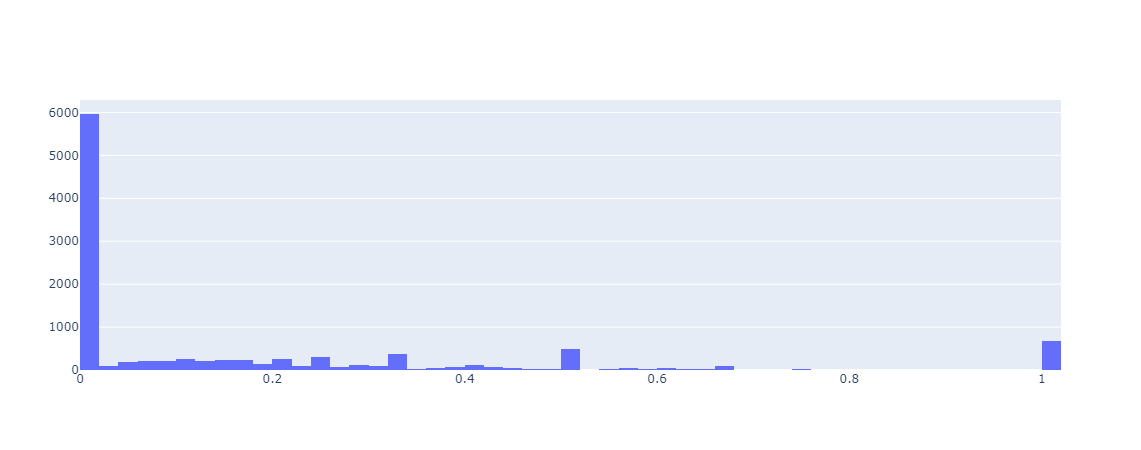

In [134]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=commentor_total_words['percent_sub_10'], histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [14]:
#8 Calculate the total number of words written by the commenter
df['comment_sent_len'] = df['comment_body'].str.count('.  ')
commentor_total_sent = df.groupby(['commentor_resolved']).agg({'comment_sent_len':['sum','mean']})
commentor_total_sent.columns = commentor_total_sent.columns.droplevel()
commentor_total_sent.columns = ['num_sent_total','num_sent_mean']
commentor_total_sent.to_csv(f'tmp_features_by_year/commentor_total_sent_{year}.csv', header=True, index=True)
commentor_total_sent.head()

num_sent_total  num_sent_mean
commentor_resolved                                      
#The-Best-Fans-in-the-NFL             184       0.786325
( . Y . )                             201       5.153846
*Legion*                                0       0.000000
-                                       0       0.000000
.                                      13       2.600000

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=commentor_total_sent.num_sent_mean.values, histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [15]:
#9 Number of comments made same day as article published, within 3 days, within 7 days, more than 7 days
articles = pd.read_csv('data/cleaned/articles.csv', header=0, parse_dates=['post_datetime'])
articles_w_dates = articles.drop_duplicates(subset=['article_url','post_datetime'])
comments_between = pd.merge(df, articles_w_dates[['article_url','post_datetime']], how='left', on='article_url')
comments_between['days_between'] = round((comments_between.comment_datetime_clean - comments_between.post_datetime) / pd.Timedelta(days=1))

def days_between_article_comment(days_between):
    try:
        days_between = int(days_between)
        if days_between == 0:
            return 'same_day'
        if days_between == 1:
            return 'next_day'
        if days_between <= 3:
            return 'within_3_days'
        if days_between <= 7:
            return 'within_1_week'    
        return 'greater_than_1_week'
    except:
        return 'same_day'
    
comments_between['days_between_article_comment'] = comments_between['days_between'].apply(days_between_article_comment)
comments_between_df = pd.pivot_table(comments_between[['article_url','days_between_article_comment','commentor_resolved']],
                                         index=['commentor_resolved'],
                                         columns=['days_between_article_comment'],
                                         aggfunc='count',
                                         fill_value=0
                                        )
comments_between_df.columns = comments_between_df.columns.droplevel()
comments_between_df.columns = [f'article_comment_{c}' for c in comments_between_df.columns]
comments_between_df['total_comments'] = comments_between_df.sum(axis=1)

comments_between_df['percent_comments_same_day'] = comments_between_df['article_comment_same_day'] / comments_between_df['total_comments']
comments_between_df['percent_comments_next_day'] = comments_between_df['article_comment_next_day'] / comments_between_df['total_comments']
comments_between_df['percent_comments_within_3_days'] = comments_between_df['article_comment_within_3_days'] / comments_between_df['total_comments']
comments_between_df['percent_comments_within_1_week'] = comments_between_df['article_comment_within_1_week'] / comments_between_df['total_comments']
comments_between_df['percent_comments_greater_than_1_week'] = comments_between_df['article_comment_greater_than_1_week'] / comments_between_df['total_comments']
comments_between_df = comments_between_df.round(1)
comments_between_df.to_csv(f'tmp_features_by_year/comments_between_df_{year}.csv', header=True, index=True)
comments_between_df.head()

article_comment_greater_than_1_week  \
commentor_resolved                                               
#The-Best-Fans-in-the-NFL                                    0   
( . Y . )                                                    0   
*Legion*                                                     0   
-                                                            0   
.                                                            0   

                           article_comment_next_day  article_comment_same_day  \
commentor_resolved                                                              
#The-Best-Fans-in-the-NFL                        42                       187   
( . Y . )                                         1                        38   
*Legion*                                          0                         1   
-                                                 2                        11   
.                                                 0                         5   

                           article_comment_within_1_week  \
commentor_resolved                                         
#The-Best-Fans-in-the-NFL                              0   
( . Y . )                                              0   
*Legion*                                               0   
-                                                      0   
.                                                      0   

                           article_comment_within_3_days  total_comments  \
commentor_resolved                                                         
#The-Best-Fans-in-the-NFL                              5             234   
( . Y . )                                              0              39   
*Legion*                                               0               1   
-                                                      1              14   
.                                                      0               5   

                           percent_comments_same_day  \
commentor_resolved                                     
#The-Best-Fans-in-the-NFL                        0.8   
( . Y . )                                        1.0   
*Legion*                                         1.0   
-                                                0.8   
.                                                1.0   

                           percent_comments_next_day  \
commentor_resolved                                     
#The-Best-Fans-in-the-NFL                        0.2   
( . Y . )                                        0.0   
*Legion*                                         0.0   
-                                                0.1   
.                                                0.0   

                           percent_comments_within_3_days  \
commentor_resolved                                          
#The-Best-Fans-in-the-NFL                             0.0   
( . Y . )                                             0.0   
*Legion*                                              0.0   
-                                                     0.1   
.                                                     0.0   

                           percent_comments_within_1_week  \
commentor_resolved                                          
#The-Best-Fans-in-the-NFL                             0.0   
( . Y . )                                             0.0   
*Legion*                                              0.0   
-                                                     0.0   
.                                                     0.0   

                           percent_comments_greater_than_1_week  
commentor_resolved                                               
#The-Best-Fans-in-the-NFL                                   0.0  
( . Y . )                                                   0.0  
*Legion*                                                    0.0  
-                                                           0.0  
.   

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=comments_between_df.percent_comments_same_day.values, name='same day', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=comments_between_df.percent_comments_next_day.values, name='next day', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=comments_between_df.percent_comments_within_3_days.values, name='within 3 days', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=comments_between_df.percent_comments_within_1_week.values, name='within 1 week', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=comments_between_df.percent_comments_greater_than_1_week.values, name='>1 week', histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [16]:
#10 Calculate which days of the week comments were made on
df['comment_date_dow'] = df['comment_datetime_clean'].dt.day_name()
comments_dow = pd.pivot_table(df[['article_url','commentor_resolved','comment_date_dow']], index=['commentor_resolved'],
                    columns=['comment_date_dow'], aggfunc='count', fill_value=0)
comments_dow.columns = comments_dow.columns.droplevel()
comments_dow.columns = ['comments_on_' + c for c in comments_dow.columns]
comments_dow['comments_on_weekend'] = comments_dow.iloc[:, 2:4].sum(axis=1)
comments_dow['comments_on_weekdays'] = comments_dow['comments_on_Monday'] + comments_dow['comments_on_Tuesday'] + comments_dow['comments_on_Wednesday'] + comments_dow['comments_on_Thursday'] + comments_dow['comments_on_Friday']
comments_dow['percentage_comments_on_weekend'] = comments_dow['comments_on_weekend'] / (comments_dow['comments_on_weekdays'] + comments_dow['comments_on_weekend']) 
comments_dow['percentage_comments_on_weekdays'] = comments_dow['comments_on_weekdays'] / (comments_dow['comments_on_weekdays'] + comments_dow['comments_on_weekend']) 
comments_dow.to_csv(f'tmp_features_by_year/comments_dow_{year}.csv', header=True, index=True)
comments_dow.head()

comments_on_Friday  comments_on_Monday  \
commentor_resolved                                                  
#The-Best-Fans-in-the-NFL                  36                  22   
( . Y . )                                   6                   8   
*Legion*                                    0                   0   
-                                           2                   1   
.                                           0                   0   

                           comments_on_Saturday  comments_on_Sunday  \
commentor_resolved                                                    
#The-Best-Fans-in-the-NFL                    53                  49   
( . Y . )                                     0                   0   
*Legion*                                      0                   0   
-                                             0                   0   
.                                             1                   0   

                           comments_on_Thursday  comments_on_Tuesday  \
commentor_resolved                                                     
#The-Best-Fans-in-the-NFL                    25                   17   
( . Y . )                                     8                   13   
*Legion*                                      0                    0   
-                                             6                    3   
.                                             1                    2   

                           comments_on_Wednesday  comments_on_weekend  \
commentor_resolved                                                      
#The-Best-Fans-in-the-NFL                     32                  102   
( . Y . )                                      4                    0   
*Legion*                                       1                    0   
-                                              2                    0   
.                                              1                    1   

                           comments_on_weekdays  \
commentor_resolved                                
#The-Best-Fans-in-the-NFL                   132   
( . Y . )                                    39   
*Legion*                                      1   
-                                            14   
.                                             4   

                           percentage_comments_on_weekend  \
commentor_resolved                                          
#The-Best-Fans-in-the-NFL                        0.435897   
( . Y . )                                        0.000000   
*Legion*                                         0.000000   
-                                                0.000000   
.                                                0.200000   

                           percentage_comments_on_weekdays  
commentor_resolved                                          
#The-Best-Fans-in-the-NFL                         0.564103  
( . Y . )                                         1.000000  
*Legion*                                          1.000000  
-                                                 1.000000  
.                                                 0.800000

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=comments_dow.percentage_comments_on_weekdays.values, histfunc='sum', histnorm='', cumulative_enabled=False))
fig.add_trace(go.Histogram(x=comments_dow.percentage_comments_on_weekend.values, histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [17]:
#12 Count number of comment made "in-season" vs "off-season"
# In-season being between 9/1 and 2/1, inclusive
df['comment_date_month'] = df['comment_datetime_clean'].dt.month
df['in_season_flag'] = np.where((df['comment_date_month'] >= 9) | (df['comment_date_month'] <= 2), 1, 0)
in_season_comments = df.groupby(['commentor_resolved']).agg({'in_season_flag':['sum'], 'commentor_resolved':['count']})
in_season_comments.columns = in_season_comments.columns.droplevel()
in_season_comments['percent_in_season_comments'] = in_season_comments['sum'] / in_season_comments['count']
in_season_comments.drop(labels=['count'], axis=1, inplace=True)
in_season_comments.columns = ['number_in_season_comments','percent_in_season_comments']
in_season_comments.to_csv(f'tmp_features_by_year/in_season_comments_{year}.csv', header=True, index=True)
in_season_comments.head()

number_in_season_comments  \
commentor_resolved                                     
#The-Best-Fans-in-the-NFL                          7   
( . Y . )                                          0   
*Legion*                                           0   
-                                                  5   
.                                                  5   

                           percent_in_season_comments  
commentor_resolved                                     
#The-Best-Fans-in-the-NFL                    0.029915  
( . Y . )                                    0.000000  
*Legion*                                     0.000000  
-                                            0.357143  
.                                            1.000000

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=in_season_comments.percent_in_season_comments.values, histfunc='sum', histnorm='', cumulative_enabled=False))
fig.show()

In [205]:
#13 Calculate the number of comments made by commentors on articles written about each NFL team
# Read in nfl teams
with open('data/reference/nfl_team_names.txt') as f:
    content = f.readlines()

# Create DataFrame of unique articles (added for efficiency)
articles_yearly = pd.DataFrame(articles[['article_body', 'article_url','post_datetime']])
articles_yearly_unique = articles_yearly.drop_duplicates()
articles_yearly_unique = articles_yearly_unique[articles_yearly_unique.post_datetime.dt.year == year]

# Flag articles by which teams they mention
nfl_teams = [x.strip() for x in content]
for team in nfl_teams:
    articles_yearly_unique[f'article_mentions_{team}'] = articles_yearly_unique['article_body'].str.lower().str.contains(f'{team}')
    print(team, end=' ')
    
# Combine comments with articles flagged by team and fix redskins/WFT name change
comments_with_teams = pd.merge(df, articles_yearly_unique, how='left', on='article_url')
comments_with_teams.dropna(axis=0, inplace=True)
comments_with_teams['article_mentions_football_team'] = comments_with_teams['article_mentions_football team'] + comments_with_teams['article_mentions_redskins']
comments_with_teams.drop(labels=['article_mentions_redskins','article_mentions_football team'], axis=1, inplace=True)

# Aggregate number of articles re: team commented on 
cols_to_sum = [c for c in comments_with_teams if 'article_mentions_' in c]
commentor_by_articles_mentioning_team = comments_with_teams.groupby(['commentor_resolved'])[cols_to_sum].apply(lambda x : x.astype(int).sum())
commentor_by_articles_mentioning_team.to_csv(f'tmp_features_by_year/commentor_by_articles_mentioning_team_{year}.csv', header=True, index=True)
commentor_by_articles_mentioning_team.head()

cardinals falcons bills ravens panthers bengals browns bears cowboys broncos lions packers texans colts chiefs chargers rams jaguars dolphins vikings patriots saints giants jets raiders eagles 49ers seahawks steelers buccaneers titans redskins football team 

article_mentions_cardinals  \
commentor_resolved                                      
#The-Best-Fans-in-the-NFL                           4   
( . Y . )                                           1   
*Legion*                                            0   
-                                                   1   
.                                                   1   

                           article_mentions_falcons  article_mentions_bills  \
commentor_resolved                                                            
#The-Best-Fans-in-the-NFL                         6                       6   
( . Y . )                                         0                       1   
*Legion*                                          0                       0   
-                                                 0                       1   
.                                                 0                       0   

                           article_mentions_ravens  article_mentions_panthers  \
commentor_resolved                                                              
#The-Best-Fans-in-the-NFL                        5                          9   
( . Y . )                                        1                          0   
*Legion*                                         0                          0   
-                                                0                          1   
.                                                1                          0   

                           article_mentions_bengals  article_mentions_browns  \
commentor_resolved                                                             
#The-Best-Fans-in-the-NFL                        11                       12   
( . Y . )                                         8                        0   
*Legion*                                          0                        0   
-                                                 1                        2   
.                                                 0                        1   

                           article_mentions_bears  article_mentions_cowboys  \
commentor_resolved                                                            
#The-Best-Fans-in-the-NFL                      15                        20   
( . Y . )                                       2                         2   
*Legion*                                        0                         0   
-                                               0                         1   
.                                               1                         1   

                           article_mentions_broncos  article_mentions_lions  \
commentor_resolved                                                            
#The-Best-Fans-in-the-NFL                         9                      20   
( . Y . )                                         3                       4   
*Legion*                                          0                       0   
-                                                 1                       0   
.                                                 0                       0   

                           article_mentions_packers  article_mentions_texans  \
commentor_resolved                                                             
#The-Best-Fans-in-the-NFL                        64                       10   
( . Y . )                                         1                        2   
*Legion*                                          0                        1   
-                                                 3                        0   
.                                                 1                        0   

                           article_mentions_colts  article_mentions_chiefs  \
commentor_resolved                                                           
#The-Best-Fans-in-the-NFL                       4                       15   
( . Y . )                                

In [206]:
# Get top team by # of comments

# Map teams to geographic regions
pac_nw = ['seahawks']
d1 = dict.fromkeys(pac_nw, 'pacific northwest')

cal = ['49ers','chargers','rams']
d2 = dict.fromkeys(cal, 'california')

sw = ['raiders','cardinals']
d3 = dict.fromkeys(sw, 'southwest')

rock = ['broncos']
d10 = dict.fromkeys(rock, 'rocky mountains')

texas = ['cowboys','texans']
d4 = dict.fromkeys(texas, 'texas')

midwest = ['chiefs','vikings','packers','bears','colts','lions',
           'browns','bengals']
d5 = dict.fromkeys(midwest, 'midwest')

ne = ['patriots']
d6 = dict.fromkeys(ne, 'new england')

midatl = ['bills','steelers','eagles','redskins','football team','jets',
         'giants','ravens']
d7 = dict.fromkeys(midatl, 'mid-atlantic')

south = ['titans','panthers','falcons','saints']
d8 = dict.fromkeys(south, 'south')

fl = ['jaguars','buccaneers', 'dolphins']
d9 = dict.fromkeys(fl, 'florida')      

d = {**d1, **d2, **d3, **d4, **d5, **d6, **d7, **d8, **d9, **d10}

commentor_by_articles_mentioning_team['top_team'] = commentor_by_articles_mentioning_team.idxmax(axis=1).str.replace('article_mentions_','')
commentor_by_articles_mentioning_team['region'] = commentor_by_articles_mentioning_team['top_team'].map(d)
commentor_by_articles_mentioning_team.head()

article_mentions_cardinals  \
commentor_resolved                                      
#The-Best-Fans-in-the-NFL                           4   
( . Y . )                                           1   
*Legion*                                            0   
-                                                   1   
.                                                   1   

                           article_mentions_falcons  article_mentions_bills  \
commentor_resolved                                                            
#The-Best-Fans-in-the-NFL                         6                       6   
( . Y . )                                         0                       1   
*Legion*                                          0                       0   
-                                                 0                       1   
.                                                 0                       0   

                           article_mentions_ravens  article_mentions_panthers  \
commentor_resolved                                                              
#The-Best-Fans-in-the-NFL                        5                          9   
( . Y . )                                        1                          0   
*Legion*                                         0                          0   
-                                                0                          1   
.                                                1                          0   

                           article_mentions_bengals  article_mentions_browns  \
commentor_resolved                                                             
#The-Best-Fans-in-the-NFL                        11                       12   
( . Y . )                                         8                        0   
*Legion*                                          0                        0   
-                                                 1                        2   
.                                                 0                        1   

                           article_mentions_bears  article_mentions_cowboys  \
commentor_resolved                                                            
#The-Best-Fans-in-the-NFL                      15                        20   
( . Y . )                                       2                         2   
*Legion*                                        0                         0   
-                                               0                         1   
.                                               1                         1   

                           article_mentions_broncos  article_mentions_lions  \
commentor_resolved                                                            
#The-Best-Fans-in-the-NFL                         9                      20   
( . Y . )                                         3                       4   
*Legion*                                          0                       0   
-                                                 1                       0   
.                                                 0                       0   

                           article_mentions_packers  article_mentions_texans  \
commentor_resolved                                                             
#The-Best-Fans-in-the-NFL                        64                       10   
( . Y . )                                         1                        2   
*Legion*                                          0                        1   
-                                                 3                        0   
.                                                 1                        0   

                           article_mentions_colts  article_mentions_chiefs  \
commentor_resolved                                                           
#The-Best-Fans-in-the-NFL                       4                       15   
( . Y . )                                

In [207]:
# 
commentor_by_articles_mentioning_team.region.value_counts(dropna=False)

midwest              3020
mid-atlantic         1718
southwest            1362
texas                1186
south                1069
new england           940
california            697
florida               438
rocky mountains       237
pacific northwest     193
NaN                   102
Name: region, dtype: int64

### Aggregate features, scale, and DR

In [142]:
# Add the path to each feature file
feature_files = os.listdir('tmp_features_by_year/')
feature_files = [f for f in feature_files if '.ipynb' not in f]

feature_files_w_path = list()
for f in feature_files:
    feature_files_w_path.append(f'tmp_features_by_year/{f}')

# Read the first file to use as seed
df = pd.read_csv(feature_files_w_path[0], header=0, index_col=0)

# Iterate through files and merge into seed
for df_ in feature_files_w_path[1:]:
    df_next = pd.read_csv(df_, header=0, index_col=0)
    df = df.merge(df_next, on='commentor_resolved', how='left')
    
print(df.shape)

(10983, 55)


In [143]:
# Replace nans with zero
df.fillna(value=0, inplace=True)
pd.options.display.max_columns = 100
df.head()

number_days_engaged_w_pft  \
commentor_resolved                                     
#The-Best-Fans-in-the-NFL                         92   
( . Y . )                                          9   
*Legion*                                           1   
-                                                 13   
.                                                  4   

                           commentor_activity_duration_in_days  \
commentor_resolved                                               
#The-Best-Fans-in-the-NFL                                  166   
( . Y . )                                                   11   
*Legion*                                                     0   
-                                                          165   
.                                                          248   

                           percent_of_year_active  num_char_total  \
commentor_resolved                                                  
#The-Best-Fans-in-the-NFL                0.551495           60626   
( . Y . )                                0.036545           21367   
*Legion*                                 0.000000             245   
-                                        0.548173            1678   
.                                        0.823920            2924   

                           num_char_mean  num_sent_total  num_sent_mean  \
commentor_resolved                                                        
#The-Best-Fans-in-the-NFL     259.085470             184       0.786325   
( . Y . )                     547.871795             201       5.153846   
*Legion*                      245.000000               0       0.000000   
-                             119.857143               0       0.000000   
.                             584.800000              13       2.600000   

                           essay  sub_10  sub_120  sub_250  sub_60  \
commentor_resolved                                                   
#The-Best-Fans-in-the-NFL      0       8       62        3     161   
( . Y . )                      2       3       13       11      10   
*Legion*                       0       0        0        0       1   
-                              0       5        2        0       7   
.                              0       0        2        2       1   

                           percent_sub_10  percent_sub_60  percent_sub_120  \
commentor_resolved                                                           
#The-Best-Fans-in-the-NFL            0.03            0.69             0.26   
( . Y . )                            0.08            0.26             0.33   
*Legion*                             0.00            1.00             0.00   
-                                    0.36            0.50             0.14   
.                                    0.00            0.20             0.40   

                           percent_sub_250  percent_essay  \
commentor_resolved                                          
#The-Best-Fans-in-the-NFL             0.01           0.00   
( . Y . )                             0.28           0.05   
*Legion*                              0.00           0.00   
-                                     0.00           0.00   
.                                     0.40           0.00   

                           article_comment_greater_than_1_week  \
commentor_resolved                                               
#The-Best-Fans-in-the-NFL                                    0   
( . Y . )                                                    0   
*Legion*                                                     0   
-                                                            0   
.                                                            0   

                           article_comment_next_day  article_comment_same_day  \
commentor_resolved                                                              
#The-Best-Fans-in-the-NFL                        42                   

In [144]:
# Drop some features
feature_set_one_v1 = ['number_days_engaged_w_pft',
                       'percent_of_year_active',
                       'num_char_mean',
                       'num_sent_mean',
                       'num_words_mean',
                       'total_comments',
                       'percent_comments_same_day',
                       'percent_comments_next_day',
                       'percent_comments_within_3_days',
                       'percent_comments_within_1_week',
                       'percent_comments_greater_than_1_week',
                       'unique_articles_commented_on',
                       'percent_comments_made_during_morning',
                       'percent_comments_made_during_afternoon',
                       'percent_comments_made_during_evening',
                       'percent_comments_made_during_night',
                       'percentage_comments_on_weekend',
                       #'percentage_comments_on_weekdays', # inverse of feature of above 
                       'percent_in_season_comments',
                       'percent_articles_w_more_than_one_comment']


feature_set_one = ['number_days_engaged_w_pft',
                       'percent_of_year_active',
#                        'num_char_mean',  # REMOVED FOR THIS ITERATION
#                        'num_sent_mean',  # REMOVED FOR THIS ITERATION
#                        'num_words_mean',  # REMOVED FOR THIS ITERATION
                       'total_comments',
                       'percent_comments_same_day',
                       'percent_comments_next_day',
                       'percent_comments_within_3_days',
                       'percent_comments_within_1_week',
                       'percent_comments_greater_than_1_week',
                       'unique_articles_commented_on',
                       'percent_comments_made_during_morning',
                       'percent_comments_made_during_afternoon',
                       'percent_comments_made_during_evening',
                       'percent_comments_made_during_night',
                       'percentage_comments_on_weekend',
                       #'percentage_comments_on_weekdays', # inverse of feature of above 
                       'percent_in_season_comments',
                       'percent_articles_w_more_than_one_comment',
                   'percent_sub_10','percent_sub_60','percent_sub_120','percent_sub_250','percent_essay'
                  ]

print(len(feature_set_one))
features_df = df[feature_set_one]
features_df.shape

21


(10983, 21)

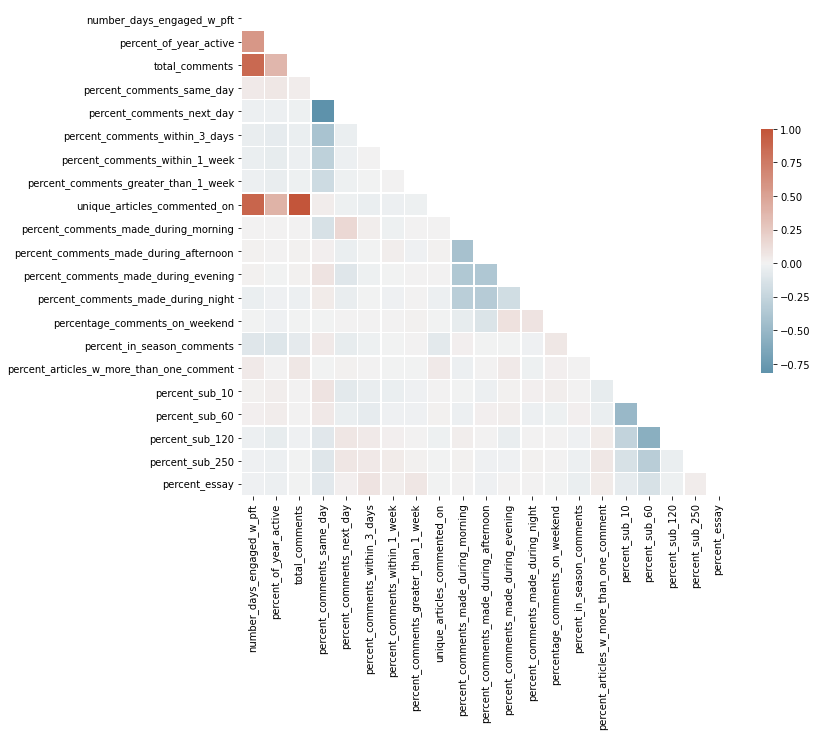

In [145]:
# Draw the heatmap with the mask and correct aspect ratio
corr = features_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [147]:
# Scale features
scaler = MinMaxScaler(feature_range=[0, 1])
df_rescaled = scaler.fit_transform(features_df)

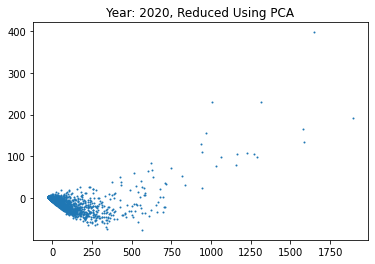

In [159]:
# Reduce dimensionality (using PCA)
pca = PCA(n_components=2, random_state=42)
commentors_pca = pca.fit_transform(df_rescaled)

# Visualize 2-dimensional data
plt.scatter(commentors_pca[:, 0], commentors_pca[:, 1], s=1)
plt.title(f'Year: {year}, Reduced Using PCA')
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10983 samples in 0.001s...
[t-SNE] Computed neighbors for 10983 samples in 3.862s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10983
[t-SNE] Computed conditional probabilities for sample 2000 / 10983
[t-SNE] Computed conditional probabilities for sample 3000 / 10983
[t-SNE] Computed conditional probabilities for sample 4000 / 10983
[t-SNE] Computed conditional probabilities for sample 5000 / 10983
[t-SNE] Computed conditional probabilities for sample 6000 / 10983
[t-SNE] Computed conditional probabilities for sample 7000 / 10983
[t-SNE] Computed conditional probabilities for sample 8000 / 10983
[t-SNE] Computed conditional probabilities for sample 9000 / 10983
[t-SNE] Computed conditional probabilities for sample 10000 / 10983
[t-SNE] Computed conditional probabilities for sample 10983 / 10983
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.863914
[t-SNE] KL

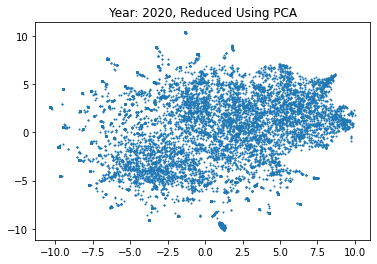

In [149]:
# Reduce dimensionality (using TSNE)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(df_rescaled)

# Visualize 2-dimensional data
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=1)
plt.title(f'Year: {year}, Reduced Using PCA')
plt.show()

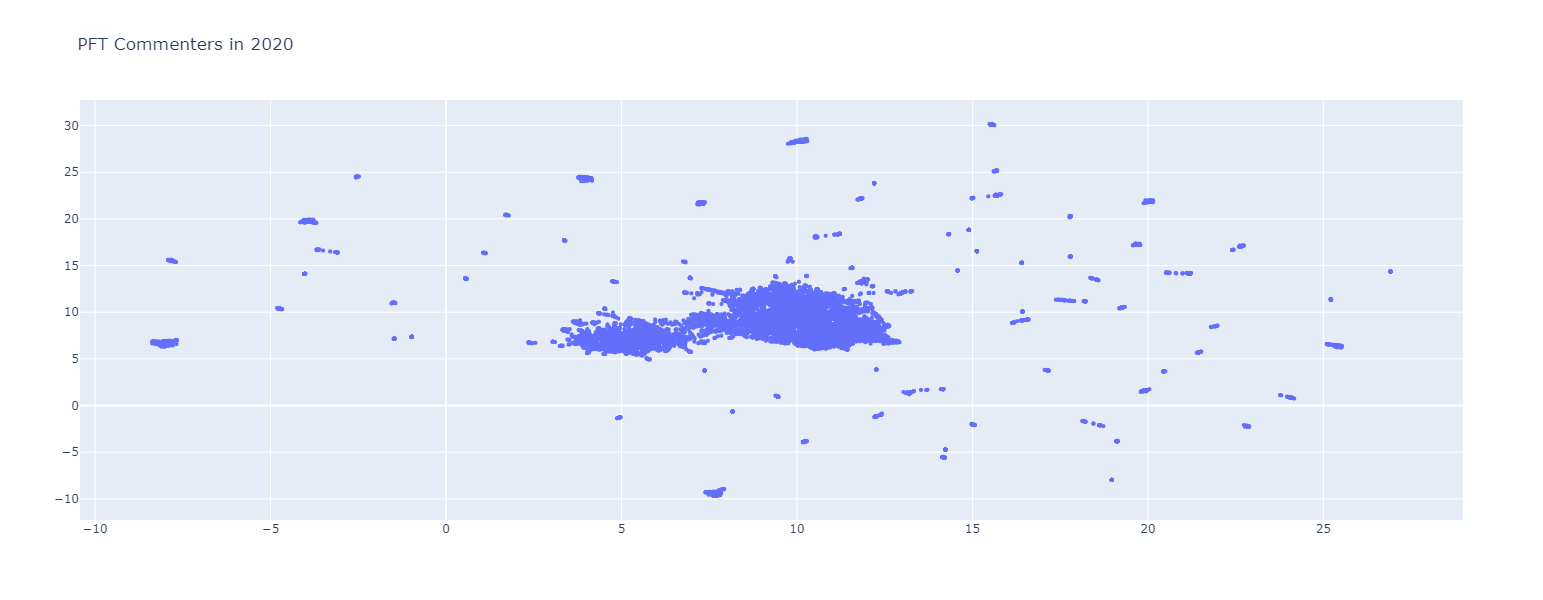

In [174]:
# Reduce dimensionality (using UMAP)
reducer = umap.UMAP(n_components=2, random_state=42, n_jobs=-1, metric='euclidean')
embedding = reducer.fit_transform(df_rescaled)

# Visualize 2-dimensional data
fig = go.Figure(data=go.Scatter(x=embedding[:, 0], y=embedding[:, 1], mode='markers', marker=dict(size=4)))
fig.update_layout(title=f'PFT Commenters in {year}')
fig.update_layout(height=600, width=600)
fig.show()

### Cluster data using DBSCAN

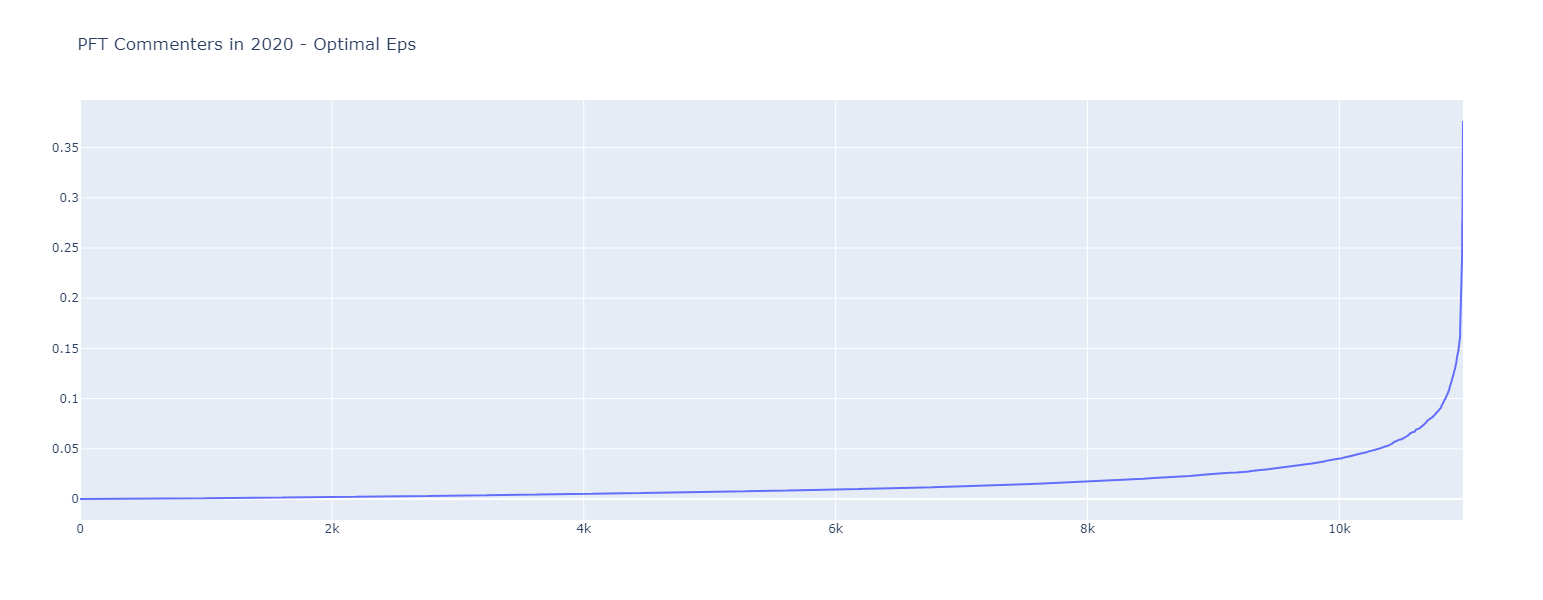

In [165]:
# Check for an optimal eps value
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(embedding)
distances, indices = nbrs.kneighbors(embedding)
distances = np.sort(distances, axis=0)
# distances = distances[:,1]
fig = go.Figure(data=go.Scatter(y=distances[:,1], mode='lines', marker=dict(size=5)))
fig.update_layout(title='PFT Commenters in 2020 - Optimal Eps')
fig.update_layout(height=600, width=600)
fig.show()

In [170]:
# Cluster
model = DBSCAN(eps=0.8, min_samples=250, n_jobs=-1)
yhat = model.fit_predict(embedding)
clusters = np.unique(yhat)
print('Clustering Complete')
clusters

Clustering Complete


array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64)

In [171]:
# Combine DR'ed and cluster assignments
embedding_df = pd.DataFrame(embedding)
embedding_df.columns = [0, 1]
embedding_df['cluster'] = yhat
cluster_distribution = embedding_df.groupby(['cluster']).size().reset_index()
cluster_distribution.columns = ['cluster','cluster_size']
cluster_distribution

cluster  cluster_size
0       -1          6351
1        0           406
2        1           957
3        2           689
4        3          1094
5        4           312
6        5           504
7        6           670

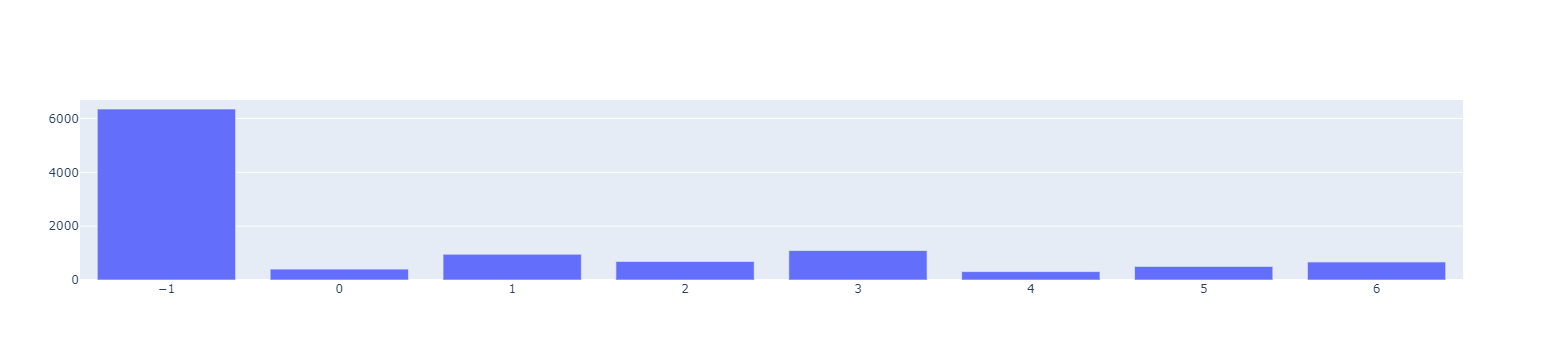

In [172]:
# Visualize the distribution of commentors by clusters
fig = go.Figure()
fig.add_trace(go.Bar(x=cluster_distribution.cluster, y=cluster_distribution.cluster_size))
fig.update_layout(height=300, width=500)
fig.show()

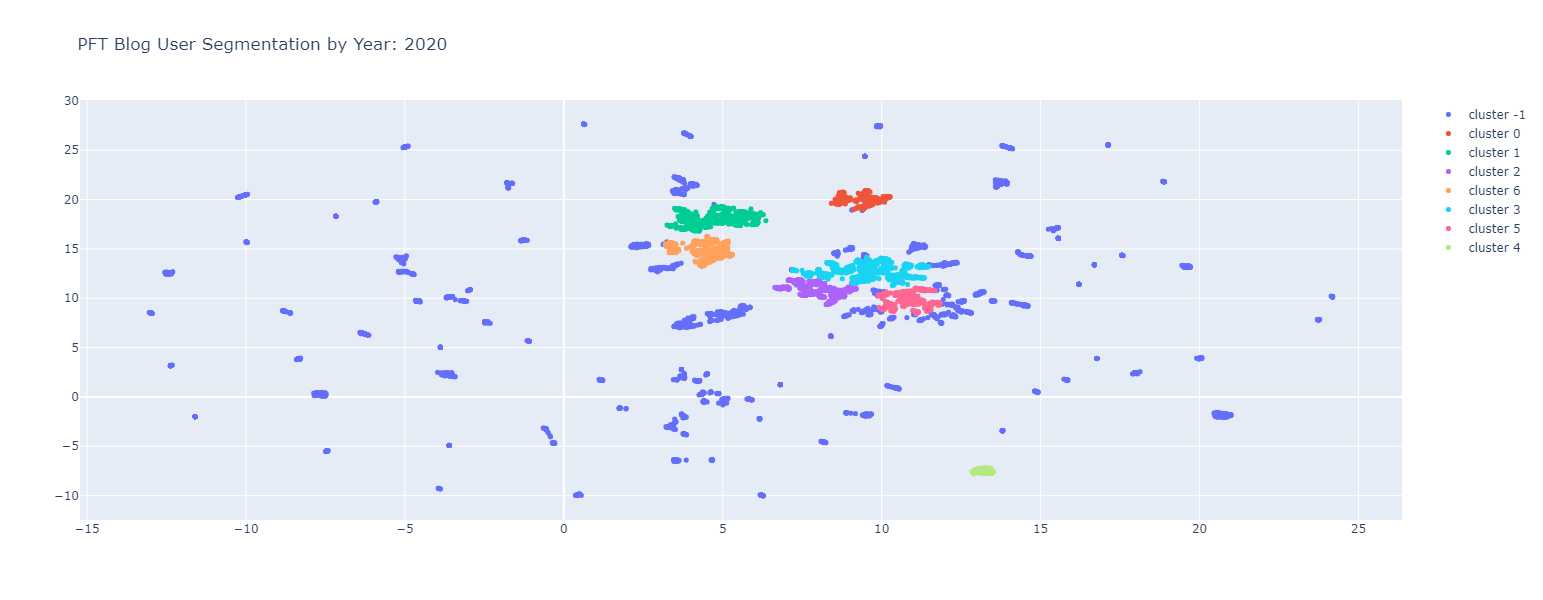

In [173]:
# Visualize clusters
fig = go.Figure()
for c in embedding_df.cluster.unique():
    df_plot = embedding_df[embedding_df.cluster == c]
    fig.add_trace(go.Scatter(x=df_plot[0], y=df_plot[1], name=f'cluster {c}', mode='markers', marker=dict(size=5)))
    
fig.update_layout(height=600, width=600, title_text=f"PFT Blog User Segmentation by Year: {year}")
fig.show()

### Determine dominant features of clusters

In [158]:
# df_rescaled['cluster'] = yhat
# df_rescaled_cluster = pd.DataFrame(df_rescaled, columns=feature_set_one)
df_rescaled_cluster = pd.DataFrame(features_df, columns=feature_set_one)
df_rescaled_cluster['cluster'] = yhat
avgs = list()
for clust in df_rescaled_cluster.cluster.unique():
    df_rescaled_cluster_single = df_rescaled_cluster[df_rescaled_cluster['cluster'] == clust]
    df_rescaled_cluster_single.drop(labels=['cluster'], axis=1, inplace=True)
    avgs.append(list(df_rescaled_cluster_single.mean()))
    
cluster_avgs = pd.DataFrame(avgs)
cluster_avgs.columns = feature_set_one
cluster_avgs

number_days_engaged_w_pft  percent_of_year_active  total_comments  \
0                  20.234556                0.555120       34.234164   
1                   1.085208                0.005828        1.161683   
2                   5.452714                0.085535        9.187465   
3                   1.000000                0.000000        1.018868   

   percent_comments_same_day  percent_comments_next_day  \
0                   0.873250                   0.102138   
1                   0.807595                   0.135247   
2                   0.881198                   0.091606   
3                   1.000000                   0.000000   

   percent_comments_within_3_days  percent_comments_within_1_week  \
0                        0.013454                        0.006943   
1                        0.035935                        0.015507   
2                        0.010912                        0.007387   
3                        0.000000                        0.000000   

   percent_comments_greater_than_1_week  unique_articles_commented_on  \
0                              0.002040                     31.462640   
1                              0.005689                      1.122784   
2                              0.007890                      8.385562   
3                              0.000000                      1.018868   

   percent_comments_made_during_morning  \
0                              0.278427   
1                              0.310611   
2                              0.290319   
3                              0.000000   

   percent_comments_made_during_afternoon  \
0                                0.341596   
1                                0.280339   
2                                0.309233   
3                                1.000000   

   percent_comments_made_during_evening  percent_comments_made_during_night  \
0                              0.216729                            0.154501   
1                              0.235353                            0.173644   
2                              0.230722                            0.158758   
3                              0.000000                            0.000000   

   percentage_comments_on_weekend  percent_in_season_comments  \
0                        0.224697                    0.354902   
1                        0.253151                    0.528201   
2                        0.300655                    0.973047   
3                        0.000000                    1.000000   

   percent_articles_w_more_than_one_comment  percent_sub_10  percent_sub_60  \
0                                  0.047417        0.178055        0.630161   
1                                  0.028149        0.159124        0.575134   
2                                  0.066590        0.187426        0.622725   
3                                  0.000000        0.000000        1.000000   

   percent_sub_120  percent_sub_250  percent_essay  
0         0.143914         0.039992       0.007603  
1         0.203908         0.055568       0.006258  
2         0.140448         0.043447       0.005579  
3         0.000000         0.000000       0.000000

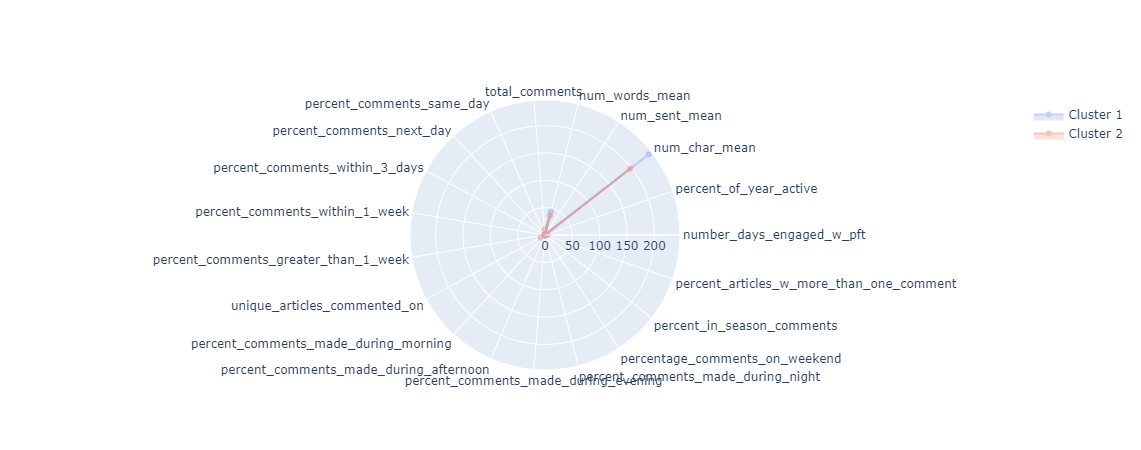

In [109]:
categories = cluster_avgs.columns

fig = go.Figure()
for row in range(1, cluster_avgs.shape[0]):
    fig.add_trace(go.Scatterpolar(
      r=cluster_avgs.iloc[row, :].values,
      theta=categories,
      fill='toself',
      name=f'Cluster {row}',
      opacity=.35
))


fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True)),
    showlegend=True)

fig.show()